In [1]:
import scanpy as sc
import bbknn

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.3


Import some pancreas data, pooled from multiple experiments. The data features a heavy batch effect.

The object's creation is detailed [here](https://nbviewer.jupyter.org/github/Teichlab/bbknn/blob/master/examples/pancreas.ipynb), in case it's of relevance.

/usr/local/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


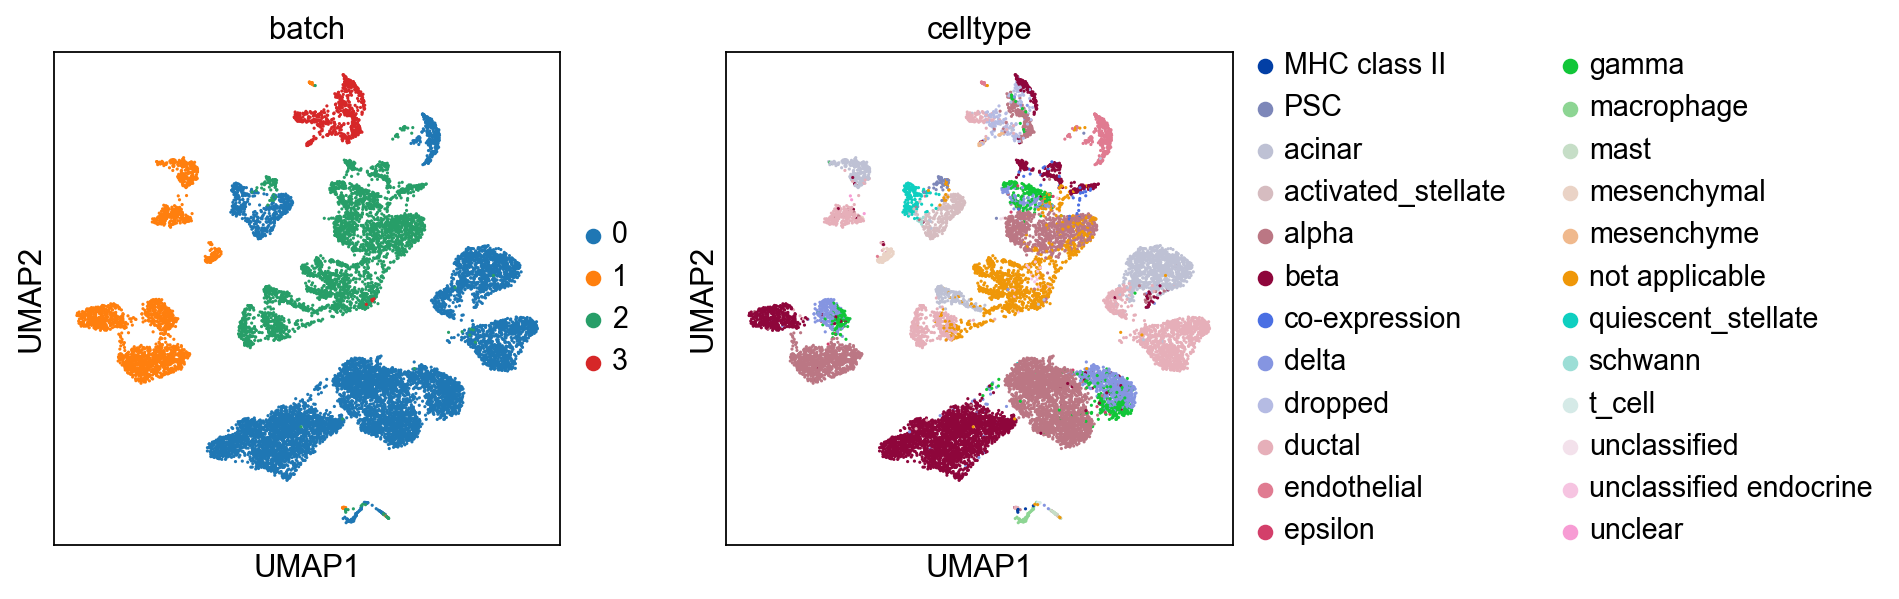

In [3]:
adata = sc.read('pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')
sc.pl.umap(adata, color=['batch','celltype'])

Run BBKNN, which computes a batch balanced neighbourhood graph, which can then be used as the basis for a UMAP. This performs batch correction at the neighbourhood graph stage, and the resulting manifold has the experiments integrated better.

Running BBKNN requires a dimensionality reduction (PCA by default) present in `.obsm` of your object, and some sort of batch variable as a column in `.obs`. The [documentation](https://bbknn.readthedocs.io/en/latest/) discusses all of the available parameters. [This](https://nbviewer.jupyter.org/github/Teichlab/bbknn/blob/master/examples/pancreas.ipynb) notebook shows the effect of some parameter choices on the data.

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


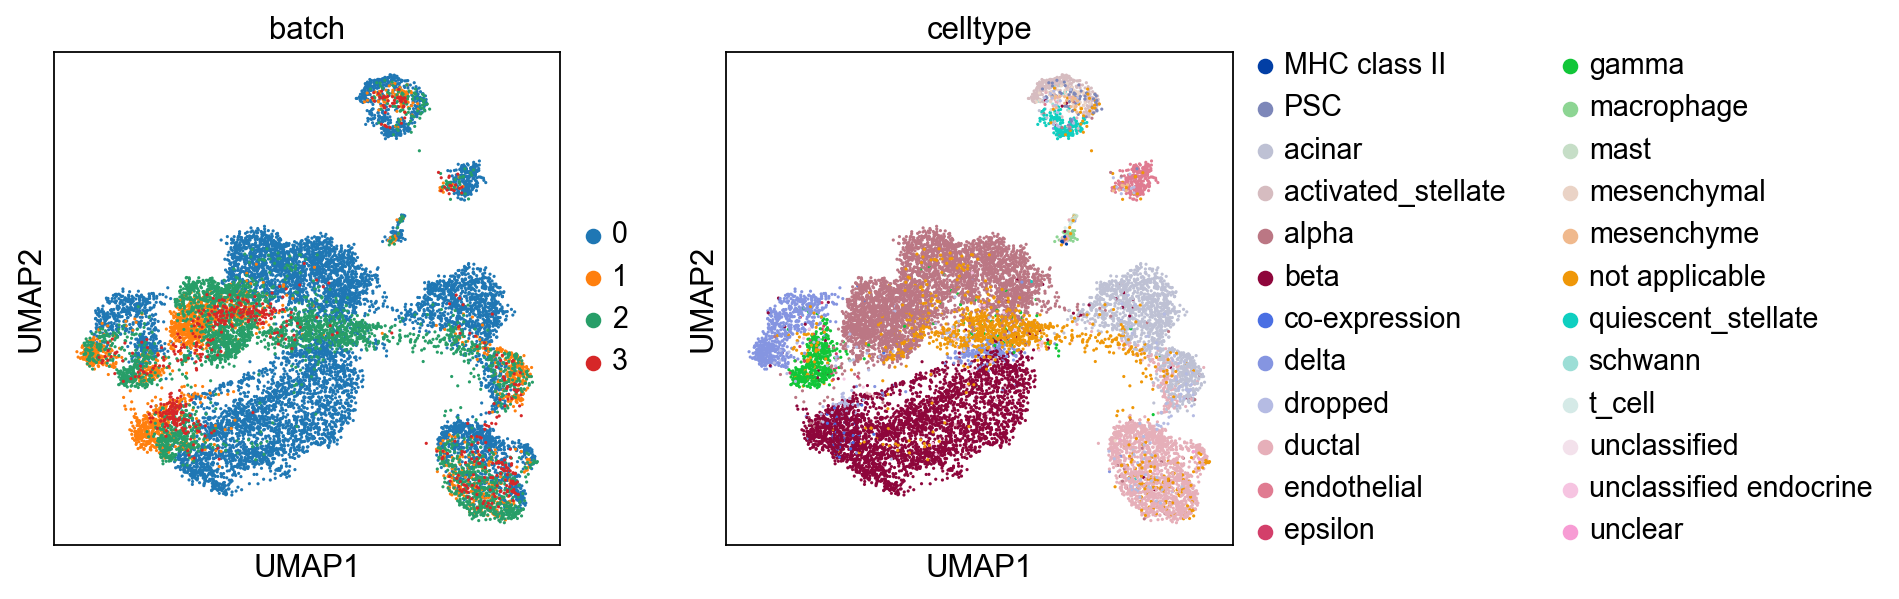

In [4]:
bbknn.bbknn(adata, batch_key='batch')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','celltype'])

[Park _et al._ 2020](https://science.sciencemag.org/content/367/6480/eaay3224.abstract) improved batch mixing by introducing ridge regression into the workflow. Regressing out technical effect while including a biological grouping into the procedure is insufficient to remove batch effect from a UMAP based on a regular neighbour graph, but helps mix batches better when used as input for BBKNN. One may not be armed in a biological grouping at the time of analysis, in which case a coarse clustering (aiming to feature as many batches as possible per cluster) can be used in  its place. This results in the following analysis flow:

    bbknn
    clustering
    ridge regression
    pca
    bbknn

Let's generate and visualise a post-BBKNN clustering.

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


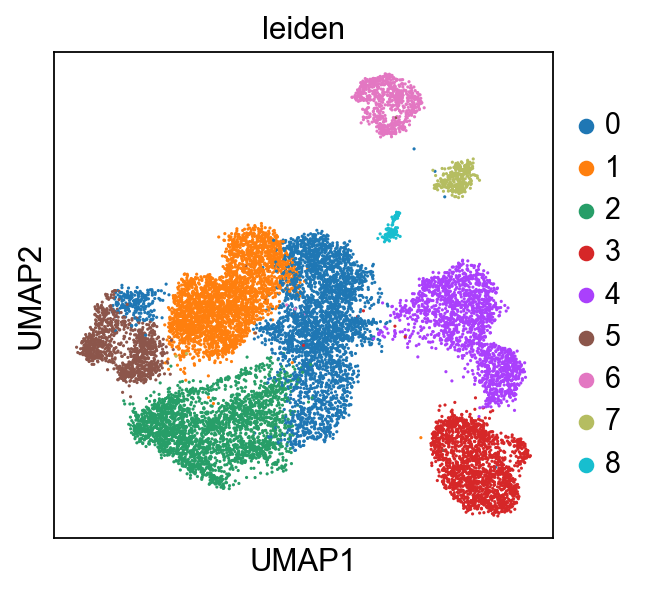

In [5]:
sc.tl.leiden(adata, resolution=0.4)
sc.pl.umap(adata, color = 'leiden')

Armed with this crude biological grouping, let's use it to call `bbknn.ridge_regression()`, and use the output of that to recompute the PCA. We can then re-run BBKNN and create a new UMAP, which mixes the batches better.

computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:06)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


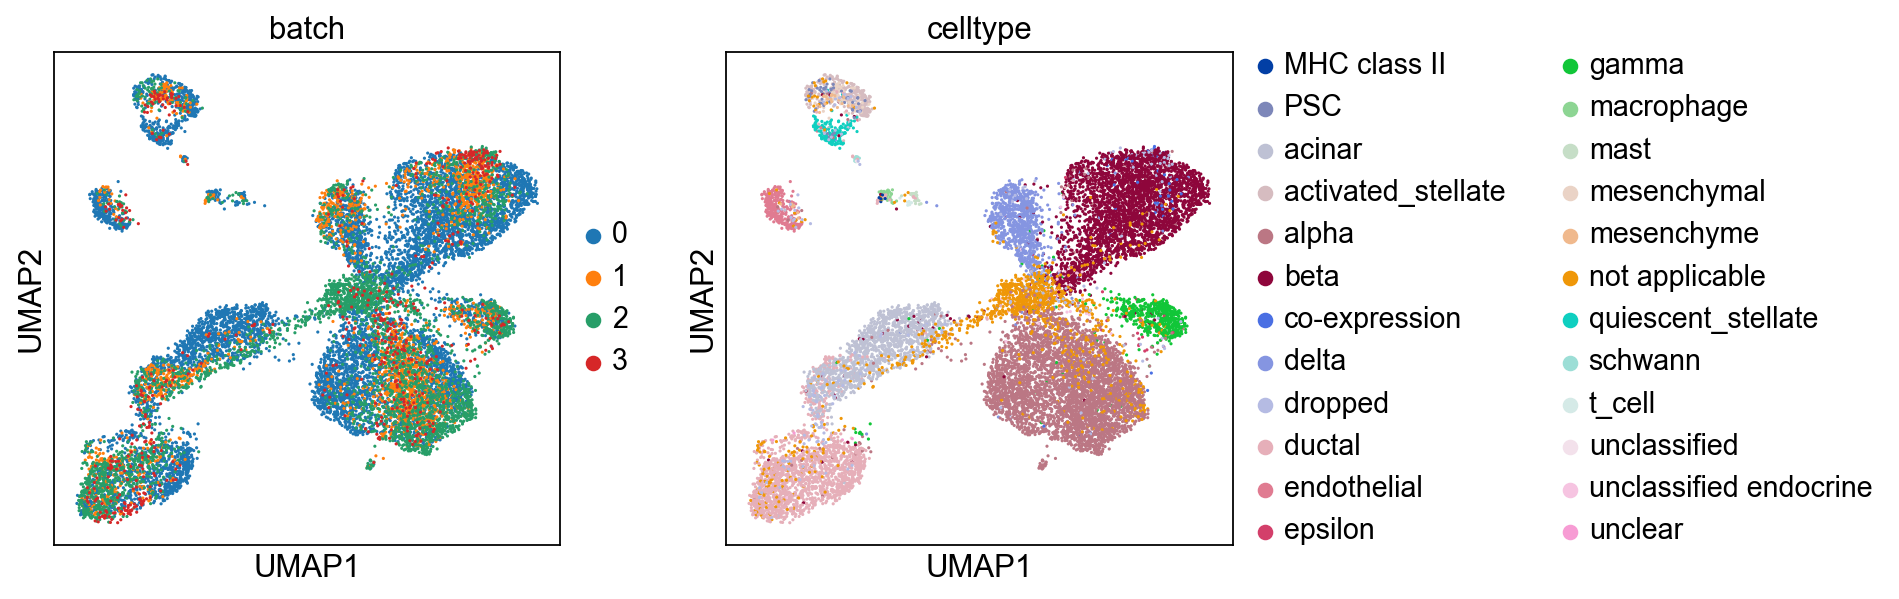

In [6]:
bbknn.ridge_regression(adata, batch_key=['batch'], confounder_key=['leiden'])
sc.pp.pca(adata)
bbknn.bbknn(adata, batch_key='batch')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','celltype'])

Seeing how the pancreas data comes with annotations from the original papers, `'celltype'` can be used as the biological grouping for ridge regression. This results in output of a similar standard to the one obtained by using the coarse clustering.

computing ridge regression


/usr/local/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:06)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


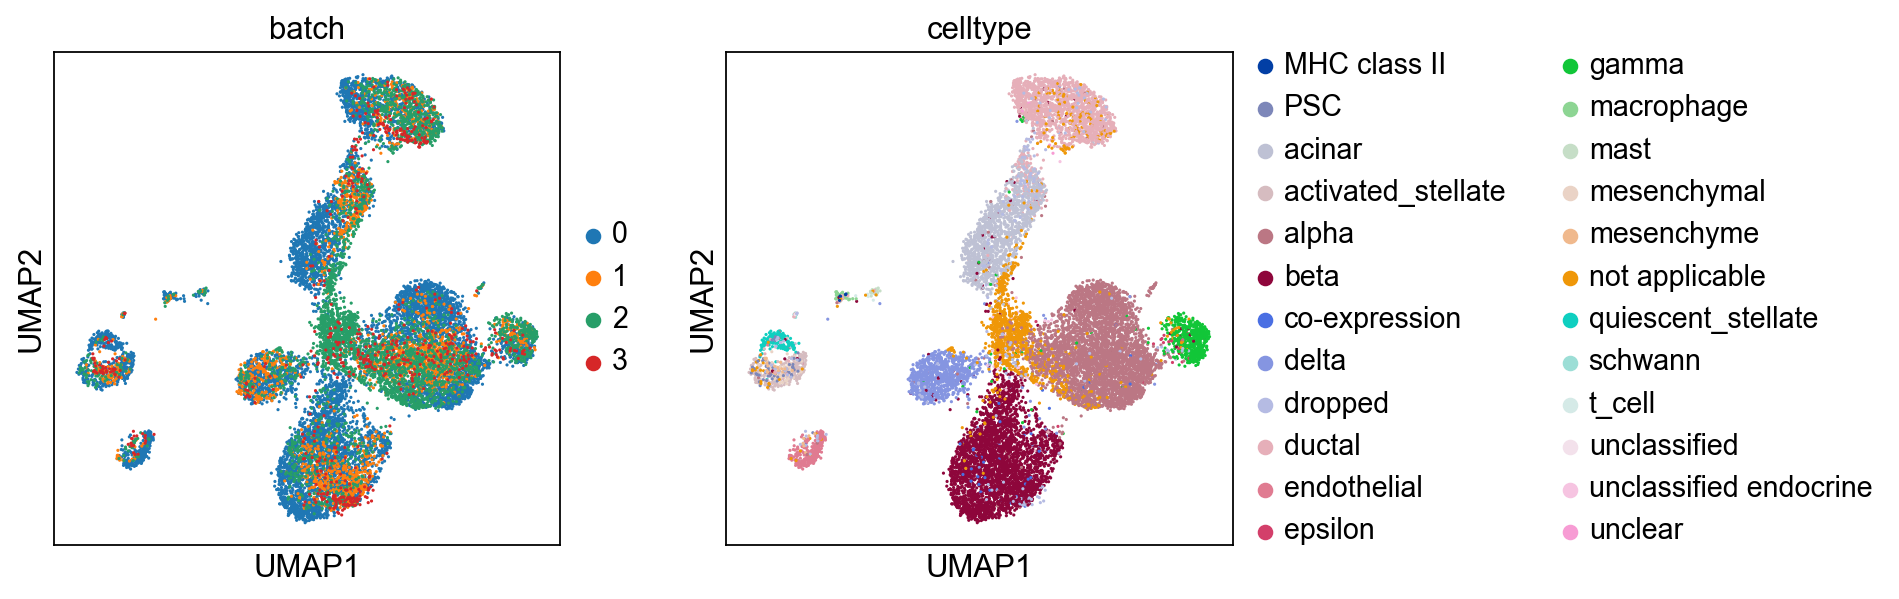

In [7]:
#reload the data to get un-regressed values back into `.X`
adata = sc.read('pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')
bbknn.ridge_regression(adata, batch_key=['batch'], confounder_key=['celltype'])
sc.pp.pca(adata)
bbknn.bbknn(adata, batch_key='batch')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','celltype'])